In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import pickle as pkl

import argparse
import os.path as osp
import random
from multiprocessing import cpu_count
import numpy as np
import tensorflow as tf

from rllab import config
from rllab.baselines.gaussian_mlp_baseline import GaussianMLPBaseline
from rllab.baselines.linear_feature_baseline import LinearFeatureBaseline
from rllab.baselines.zero_baseline import ZeroBaseline
from rllab.envs.normalized_env import normalize
from rllab.misc import logger
from rllab.misc.instrument import VariantGenerator
from rllab.misc.instrument import run_experiment_lite
from sandbox.carlos.point_env_randgoal import PointEnvRandGoal, StraightDemo
from sandbox.rocky.tf.algos.sensitive_lfd_trpo import SensitiveLfD_TRPO
from sandbox.rocky.tf.envs.base import TfEnv
from sandbox.rocky.tf.policies.sens_lfd_minimal_gauss_mlp_policy import SensitiveLfdGaussianMLPPolicy
from sandbox.rocky.tf.policies.gaussian_mlp_policy import GaussianMLPPolicy
from sandbox.young_clgan.logging import HTMLReport
from sandbox.young_clgan.logging import format_dict

/Users/florensacc/anaconda2/envs/rllab-maml/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/florensacc/anaconda2/envs/rllab-maml/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/florensacc/anaconda2/envs/rllab-maml/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
/Users/florensacc/anaconda2/envs/rllab-maml/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use

In [2]:
v={'env_noise': 0.05, 
   'tolerance': 0.1, 
   'fast_learning_rate': 0.001, 
   'max_path_length': 100, 
   'num_grad_updates': 1, 
   'meta_step_size': 0.01,
   'demo_batch_size': 100,
   'batch_size': 1000,
   'discount': 0.99}

In [3]:
env = TfEnv(normalize(PointEnvRandGoal(noise=v['env_noise'], tolerance=v['tolerance'])))

In [4]:
policy = SensitiveLfdGaussianMLPPolicy(
    name="policy",
    env_spec=env.spec,
    grad_step_size=v['fast_learning_rate'],
    hidden_nonlinearity=tf.nn.relu,
    hidden_sizes=(100, 100),
)

demo_policy = StraightDemo(env_spec=env.spec)

In [5]:
obs_demo_vars = env.observation_space.new_tensor_variable(
    'demo_obs',
    extra_dims=1,
    )
action_demo_vars = env.action_space.new_tensor_variable(
    'demo_actions',
    extra_dims=1,
    )

In [6]:
dist = policy.distribution

In [7]:
old_dist_info_demo_vars = {
    k: tf.placeholder(tf.float32, shape=[None] + list(shape), name='old_%s' % (k))
    for k, shape in dist.dist_info_specs
    }
old_dist_info_vars_demo_list = [old_dist_info_demo_vars[k] for k in dist.dist_info_keys] # list version of the dict

In [8]:
input_list = [obs_demo_vars, action_demo_vars]

dist_info_demo_vars, params = policy.dist_info_sym(obs_demo_vars, all_params=policy.all_params)

kl = dist.kl_sym(old_dist_info_demo_vars, dist_info_demo_vars)

logli_demo = dist.log_likelihood_sym(action_demo_vars, dist_info_demo_vars)

bc_loss = - tf.reduce_mean(logli_demo)
tf.summary.scalar('bc_loss', bc_loss)

<tf.Tensor 'bc_loss:0' shape=() dtype=string>

In [9]:
def update_dist_info_lfd_sym(surr_obj, params, step_size=0.01):

    gradients = dict(
        zip(update_param_keys, tf.gradients(surr_obj, [params[key] for key in update_param_keys])))
    new_params = dict(
        zip(update_param_keys, [params[key] - step_size * gradients[key] for key in update_param_keys]))
    
    return new_params

In [10]:
update_param_keys = params.keys()
step_size = 0.001 # define this as input to function

new_params = update_dist_info_lfd_sym(bc_loss, params, step_size)

new_dist_info_demo_vars, new_params = policy.dist_info_sym(obs_demo_vars, all_params=new_params)  # try to replace policy!!

In [11]:
sess = tf.InteractiveSession()
initializer = tf.global_variables_initializer()
sess.run(initializer)

In [12]:
# I should be done constructing the graph for the simple LFD update. Let's try it out!

In [13]:
from rllab.sampler.utils import rollout, rollout_demo
sess = tf.InteractiveSession()

start = env.reset(objective_params=[3,3])
goal = env.objective_params

initializer = tf.global_variables_initializer()
sess.run(initializer)

demos = [rollout_demo(env, demo_policy, v['max_path_length']) for _ in range(v['demo_batch_size'])]
demos_flat_obs = np.concatenate([demo['observations'] for demo in demos], axis=0)
demos_flat_act = np.concatenate([demo['actions'] for demo in demos], axis=0)

resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resetting env_goal to:  [3, 3]
resettin

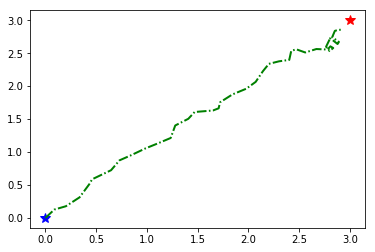

In [14]:
plt.plot(*goal, 'r*', markersize=10)
plt.plot(*start, 'b*', markersize=10)
plt.plot(demos[0]['observations'][:, 0], demos[0]['observations'][:, 1], '-.g', linewidth=2)

In [15]:
# from rllab.sampler.utils import rollout
# pre_update = rollout(env, policy, v['max_path_length'])

In [16]:
input_list_dict = {obs_demo_vars : demos_flat_obs, action_demo_vars : demos_flat_act}

In [17]:
print(tf.get_default_session())

In [18]:
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter('data/tf_summaries/',
                                      sess.graph)

summary, bc_loss_val, new_params_vals = sess.run([merged, bc_loss, new_params], feed_dict=input_list_dict)

train_writer.add_summary(summary, 0)

In [19]:
from sandbox.rocky.tf.envs.vec_env_executor import VecEnvExecutor
vect_env = VecEnvExecutor(envs=[env], max_path_length=v['max_path_length'])

bc_loss_val = sess.run(bc_loss, feed_dict=input_list_dict)
exp_name = 'LFD_noise{}_lr{}_demos{}'.format(v['env_noise'], v['fast_learning_rate'], v['demo_batch_size'])
print('Loss after update %d: %f' % (0, bc_loss_val))
losses = []
paths = []
for i in range(5000):  # for more steps I should 
    bc_loss_val, new_params_vals = sess.run([bc_loss, new_params], feed_dict=input_list_dict)
    policy.assign_params(policy.all_params, new_params_vals)
    losses.append(bc_loss_val)
    if i % 500 == 0:
        print('Loss after update %d: %f' % (i, bc_loss_val))
        paths.append(rollout(vect_env, policy, v['max_path_length']))

with open('Figures/lfd/'+exp_name+'_loss.pkl', 'wb') as outfile:
    pkl.dump(losses, outfile)

Loss after update 0: 2.595505
Loss after update 0: 2.595505
Loss after update 500: 1.658516
Loss after update 1000: 1.032555
Loss after update 1500: 0.207869
Loss after update 2000: -0.482788
Loss after update 2500: -1.236960
Loss after update 3000: -1.713645
Loss after update 3500: -2.036734
Loss after update 4000: -2.347678
Loss after update 4500: -2.614258


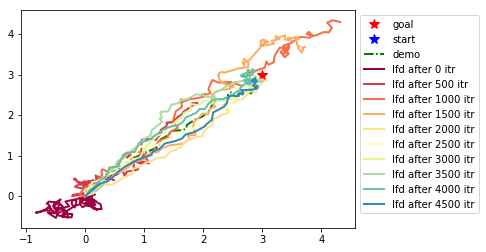

In [20]:
plt.clf()
plt.plot(*goal, 'r*', markersize=10, label='goal')
plt.plot(*start, 'b*', markersize=10, label='start')
plt.plot(demos[0]['observations'][:, 0], demos[0]['observations'][:, 1], '-.g', linewidth=2, label='demo')

cmap = matplotlib.cm.get_cmap('Spectral')
len_paths = len(paths)
for i, path in enumerate(paths):
    plt.plot(path['observations'][:, 0], path['observations'][:, 1], color=cmap(i/len_paths), linewidth=2, label='lfd after %i itr' % (i * 500))
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig('Figures/lfd/'+exp_name+'.png')

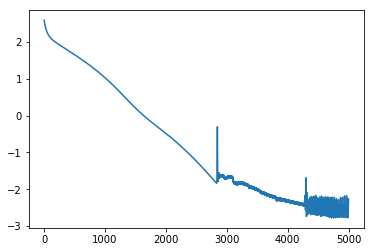

In [21]:
plt.plot(losses)
plt.savefig('Figures/lfd/Loss_noise{}_lr{}_demos{}.png'.format(v['env_noise'], v['fast_learning_rate'], v['demo_batch_size']))